In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from datetime import datetime
from scipy.optimize import fsolve
from scipy.optimize import curve_fit

In [11]:
folder_path = './'
TRScans = []
ZZplots = []
currents_ZZ = []
start_time = datetime(year=2024, month=11, day=15, hour=11, minute=0, second=0)
end_time = datetime(year=2024, month=11, day=15, hour=13, minute=30, second=0)
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        file_path = os.path.join(folder_path, file)
        # Get the file creation time
        #print(file)
        creation_time = datetime.fromtimestamp(os.path.getmtime(file_path))
        if creation_time > start_time and creation_time < end_time:
            if 'TRScan' in file and '_CP_' in file:
                TRScans.append(pd.read_csv(file, names = ['time', 'potential', 'current']))
            if "EIS" in file and file.endswith("Acm2.csv"):
                ZZplots.append(pd.read_csv(file, names = ['1', '2', '3']))
                ZZplots[-1]['2'] *= -1
                match1 = re.search(r'EIS (\d+(\.\d+)?)A', file)
                match2 = re.search(r'EIS(\d+(\.\d+)?)A', file)
                match3 = re.search(r'_(\d+(\.\d+)?)A', file)
                if match1:
                    value = match1.group(1)
                    currents_ZZ.append(value)
                if match2:
                    value = match2.group(1)
                    currents_ZZ.append(value)
                if match3:
                    value = match3.group(1)
                    currents_ZZ.append(value)

            

In [12]:
print(os.listdir(folder_path))

['1512_241115TRScan1_V99831_CP_0.600Acm2.idf', '1471_241115EISScan3_V99831_cp_acid.idf', '1472_241115EISScan1_V99831_filename.csv', '1494_241115TRScan1_V99831_CP_0.020Acm2.csv', '1524_241115TRScan1_V99831_CP_0.010Acm2.csv', '1503_241115EISScan1_V99831_EIS_0.001Acm2.idf', '1508_241115TRScan1_V99831_CP 1Acm2.csv', '1499_241115EISScan1_V99831_EIS_0.005Acm2.csv', '1470_241115TRScan2_V99831_cp_acid.csv', '1521_241115EISScan1_V99831_EIS_0.050Acm2.idf', '1467_241115EISScan7_V99831_cp_acid.idf', '1474_241115EISScan1_V99831_filename.idf', '1472_241115EISScan1_V99831_filename.idf', '1494_241115TRScan1_V99831_CP_0.020Acm2.idf', '1471_241115EISScan3_V99831_cp_acid.csv', '1512_241115TRScan1_V99831_CP_0.600Acm2.csv', '1524_241115TRScan1_V99831_CP_0.010Acm2.idf', '1467_241115EISScan7_V99831_cp_acid.csv', '1521_241115EISScan1_V99831_EIS_0.050Acm2.csv', '1470_241115TRScan2_V99831_cp_acid.idf', '1499_241115EISScan1_V99831_EIS_0.005Acm2.idf', '1474_241115EISScan1_V99831_filename.csv', '1503_241115EISScan

In [13]:
print(len(TRScans))
print(len(ZZplots))

22
28


0.9453289359632872 0.41460000163523886 1.100002279137992 1.557897202112622


/var/folders/xl/v8lcvy855_39wt1534xvs_hw0000gn/T/ipykernel_13944/3129476434.py:12: RuntimeWarning: invalid value encountered in log
  (a, b, c, d), _ = curve_fit(lambda x, a_, b_, c_, d_: np.log(a_*(x**b_) + c_) + d_, xdata = Js, ydata = Vs)


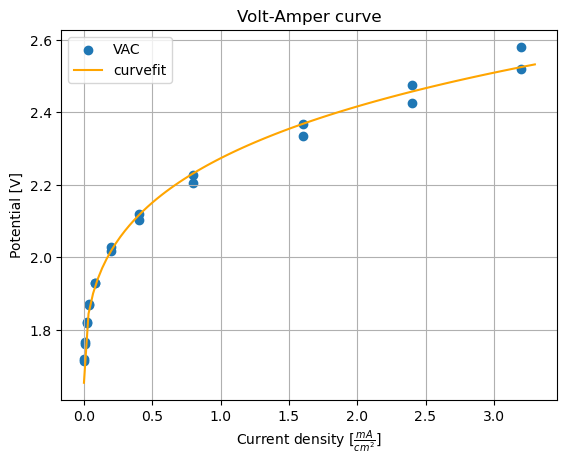

In [14]:
Js = []
Vs = []


for trscan in TRScans:
    J = np.mean(trscan['current'][-100:])
    V = np.mean(trscan['potential'][-100:])
    Js.append(J)
    Vs.append(V)

Js = np.array(Js)
(a, b, c, d), _ = curve_fit(lambda x, a_, b_, c_, d_: np.log(a_*(x**b_) + c_) + d_, xdata = Js, ydata = Vs)

x = np.linspace(0,3.3,100)
plt.scatter(Js, Vs, label = 'VAC')
plt.plot(x, np.log(a*(x**b) + c) + d, label = 'curvefit', color = 'orange')
plt.grid()
plt.title('Volt-Amper curve')
plt.xlabel('Current density [$\\frac{mA}{cm^2}$]')
plt.ylabel('Potential [V]')
plt.legend()
print(a, b, c, d)

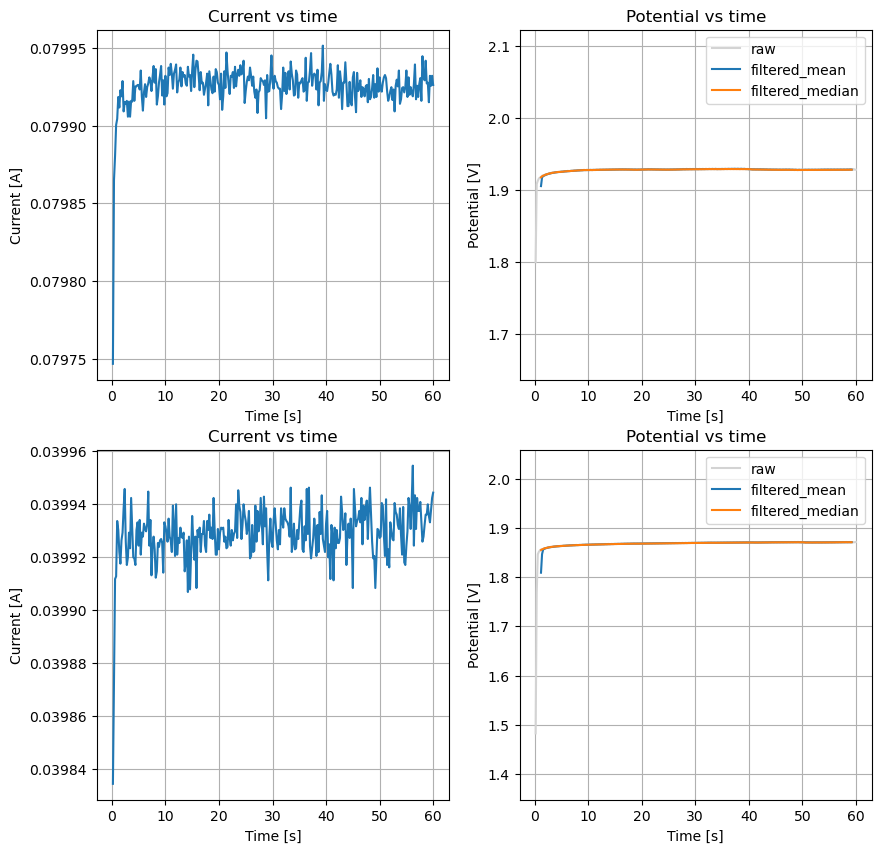

In [15]:
data = TRScans[:2]
ws = 10


fig, ax = plt.subplots(ncols = 2, nrows = len(data), figsize = (10, 5*len(data)))
for i in range(len(data)):
    data[i]['potential_filtered_mean'] = data[i]['potential'].rolling(window=ws, center=True).mean()
    data[i]['potential_filtered_median'] = data[i]['potential'].rolling(window=ws, center=True).median()
    ax[i, 0].set_title('Current vs time')
    ax[i, 0].plot(data[i]['time'], data[i]['current'])
    ax[i, 0].grid()
    ax[i, 0].set_xlabel('Time [s]')
    ax[i, 0].set_ylabel('Current [A]')

    ax[i, 1].set_title('Potential vs time')
    ax[i, 1].plot(data[i]['time'], data[i]['potential'], label = 'raw', color = 'lightgrey')
    ax[i, 1].plot(data[i]['time'], data[i]['potential_filtered_mean'], label = 'filtered_mean')
    ax[i, 1].plot(data[i]['time'], data[i]['potential_filtered_median'], label = 'filtered_median')
    ax[i, 1].grid()
    ax[i, 1].set_xlabel('Time [s]')
    ax[i, 1].set_ylabel('Potential [V]')
    ax[i, 1].legend()
    ax[i, 1].set_ylim(min(data[i]['potential'])/1.1, max(data[i]['potential'])*1.1)

In [16]:
Rs = []

for zzplot in ZZplots:
    for i in range(zzplot['1'].size-1):
        if zzplot['2'][i]*zzplot['2'][i+1] < 0:
            pol = np.polyfit([zzplot['1'][i], zzplot['1'][i+1]], [zzplot['2'][i],zzplot['2'][i+1]], 1)
            res = fsolve(lambda x: np.polyval(pol, x), [0])[0]
            res = max(res, 0)
            Rs.append(res)
            break



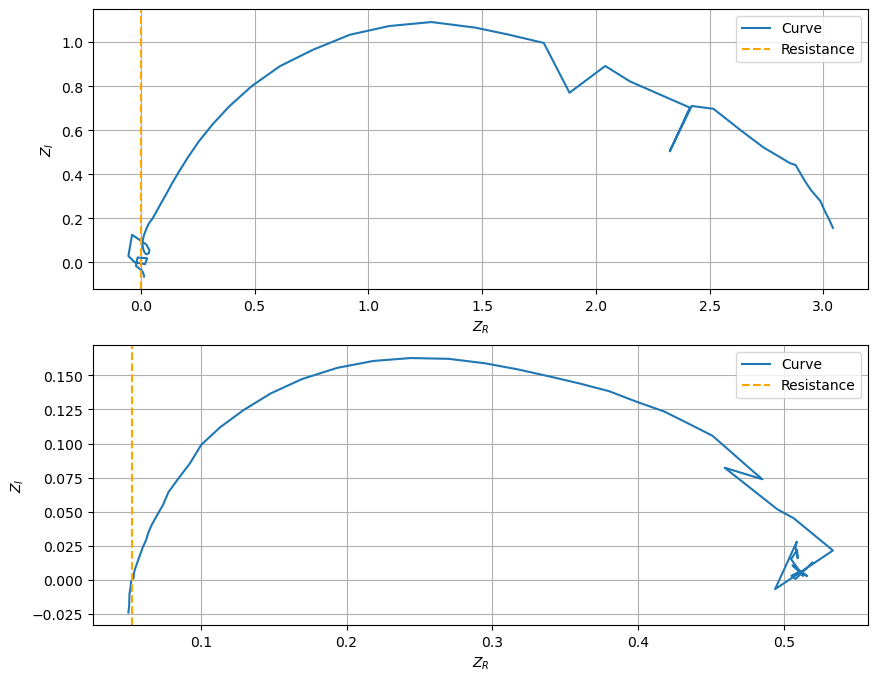

In [17]:
data = ZZplots[:2]
#data['potential_filtered'] = medfilt(data['potential'], kernel_size=11)
ws = 10


fig, ax = plt.subplots(nrows = len(data), figsize = (10, 4*len(data)))
for i in range(len(data)):
    ax[i].plot(data[i]['1'], data[i]['2'], label = 'Curve')
    ax[i].grid()
    ax[i].set_xlabel('$Z_R$')
    ax[i].set_ylabel('$Z_I$')
    ax[i].axvline(Rs[i], linestyle ='--', color = 'orange', label = 'Resistance')
    ax[i].legend(loc = 'upper right')



Text(0, 0.5, 'Resistance [$\\Omega$]')

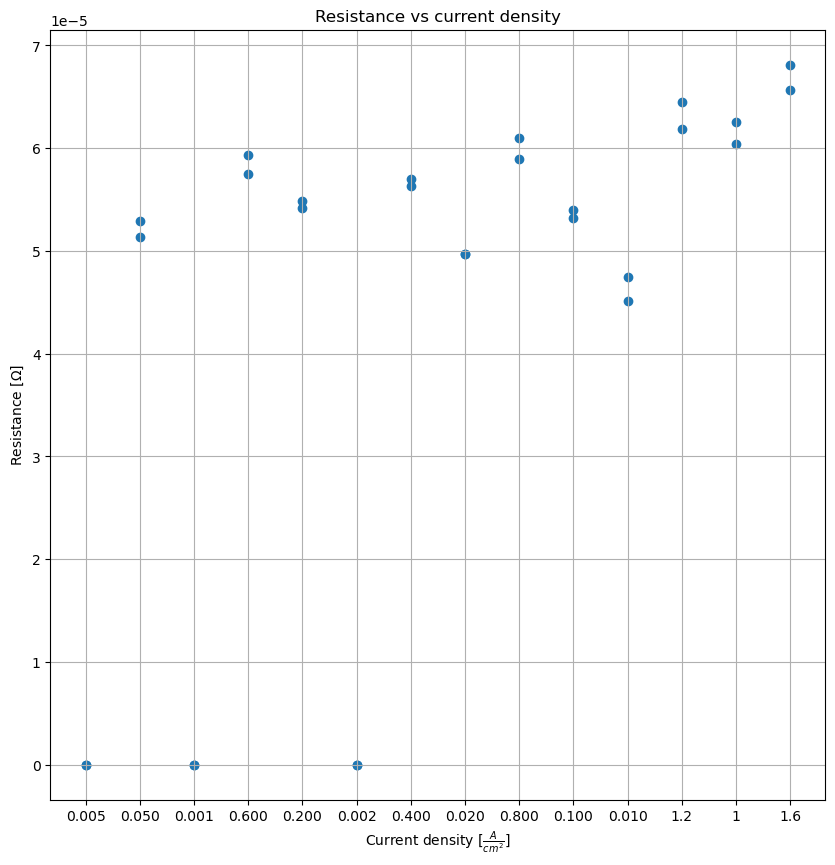

In [18]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.scatter(currents_ZZ, np.array(Rs)/1000)
ax.grid()
ax.set_title('Resistance vs current density')
ax.set_xlabel('Current density [$\\frac{A}{cm^2}$]')
ax.set_ylabel('Resistance [$\\Omega$]')